# <p style="text-align: center;"> All data processing, analyses, and figures from the Ultimate Manuscript. </p>



## Data importing and cleaning
(To see associated experimental stimuli script, [go here](https://bitbucket.org/smweis/ultimate-reference-frames))

In [10]:
# import a few things

# ignore warnings for better viewing. 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm
from IPython.core.debugger import set_trace



In [11]:
# Get Data

# the data importing and processing steps have been carried out to generate mainData.csv (available on Github)

navData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/nav_data.csv')
frizData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/friz_data.csv')

# this contains things like SBSOD, other self-report measures, and demographics
additionalData = pd.read_csv('https://raw.githubusercontent.com/smweis/Ultimate/master/data/additional_data.csv')

# Recode "psychopycode to participant"
additionalData['participant'] = additionalData['psychopycode']

# Set one answer in Friz_Handedness to left_right. this will ensure this subject is removed when only one type of handedness is being analyzed.
for i in additionalData['Friz_Handedness']:
    if 'Both' in i:
        additionalData.loc[additionalData['Friz_Handedness'] == i,['Friz_Handedness']] = 'Left_Right'



In [12]:
# Clean data functions for use with chooseYourData()

def removeHighRTs(howManySDs,dv,data,withinCondition): 
    # thresholds RT data based on each participant's mean
 
    # Returns a dataset for use with chooseYourData()
    
    # howManySDs: how many standard deviations above the mean should be trimmed
    # dv: should be Trials_responsert
    # data: should be df
    # withinCondition: if True, will trim RTs separately for Frisbee vs. Navigation within participant
    
    # quick input check
    if howManySDs <= 0:
        return data
    
    if withinCondition:
         # pivot by condition and participant  
        rtMeans = data.pivot_table(index='participant',columns=['condition'],values=dv,aggfunc=np.mean)
        rtSTDs = data.pivot_table(index='participant',columns=['condition'],values=dv,aggfunc=np.std)    
        
        # if this is the first loop, create the new dataframe
        firstTimeFlag = True
        for i in rtMeans.index:
            # split the dataset into Frisbee and Navigation, then threshold by the RT mean + howManySDs*SD for each condition.
            rtThreshFriz = rtMeans.Frisbee[i] + rtSTDs.Frisbee[i]*howManySDs
            rtThreshNav = rtMeans.Navigation[i] + rtSTDs.Navigation[i]*howManySDs
 
            # select just that participant's data
            pData = data.loc[data.index == i]
            
            # select by condition
            a = pData.loc[pData['condition'] == 'Frisbee']
            
            # keep just trials faster than the threshold for that condition
            a = a.loc[a[dv] < rtThreshFriz]
            # ditto for the other condition
            b = pData.loc[pData['condition'] == 'Navigation']
            b = b.loc[b[dv] < rtThreshNav]
    
            # then concatenate the two conditions back together
            pDataThresh = pd.concat([a,b])
    
            if firstTimeFlag:
                dataThresh = pDataThresh[:]
                firstTimeFlag = False
            else:
                dataThresh = pd.concat([dataThresh,pDataThresh])
    
        dataThresh = dataThresh.loc[dataThresh[dv] > 0]

        return dataThresh

    
    else:
    
        #calculate mean and Std. deviation per participant
        rtMeans = data.pivot_table(index='participant',values=dv,aggfunc=np.mean)
        rtSTDs = data.pivot_table(index='participant',values=dv,aggfunc=np.std)
    
        firstTimeFlag = True
        rtThresh = []
        for i,j in enumerate(rtMeans.index):
  
            rtThresh.append(rtMeans.Trials_responsert[j] + rtSTDs.Trials_responsert[j]*howManySDs)
        
            pData = data.loc[data.index == j]
            pData = pData.loc[pData[dv] < rtThresh[i]]
            
        
            if firstTimeFlag:
                dataThresh = pData[:]
                firstTimeFlag = False
            else:
                dataThresh = pd.concat([dataThresh,pData])
    
        dataThresh = dataThresh.loc[dataThresh[dv] > 0]
    
        return dataThresh
    

def removeWrongAnswers(dv,data):
    # leaves in correct answers (coded in the DV as 1)
    dataCorrect = data.loc[data[dv] == 1]
    return dataCorrect


def removeAccuracyOutliers(howManySDs,dv,data,necadddata):
    # remove outliers on accuracy for each condition (but remove them from the whole dataset)
    if howManySDs <= 0:
        return data,necadddata
    
    accuracyPivot = data.pivot_table(index='participant',columns=['condition'],values=dv,aggfunc=np.mean)

    corrMeans = accuracyPivot.mean()
    corrSTDs = accuracyPivot.std()

    corr_thresh_friz = accuracyPivot.Frisbee > corrMeans.Frisbee - corrSTDs.Frisbee*howManySDs
    lowCorr_friz = accuracyPivot[~corr_thresh_friz]
    lowCorr_friz = lowCorr_friz.index

    corr_thresh_nav = accuracyPivot.Navigation > corrMeans.Navigation - corrSTDs.Navigation*howManySDs
    lowCorr_nav = accuracyPivot[~corr_thresh_nav]
    lowCorr_nav = lowCorr_nav.index

    lowCorr = lowCorr_nav.union(lowCorr_friz)
    df_good = data.loc[~data.index.isin(lowCorr)]
    nad = necadddata[~necadddata.index.isin(lowCorr)]
    return df_good,nad

def selectHandedness(handedness,data,nad):
    # Remove 'left' or 'right' handers
    left = ['l','L','left','Left']
    right = ['r','R','right','Right']
    if handedness in left:
        handedness = 'Left'
        nad = nad[nad['Friz_Handedness'] == handedness]
        data = data.loc[data.index.isin(nad.index)]
    elif handedness in right:
        handedness = 'Right'
        nad = nad[nad['Friz_Handedness'] == handedness]
        data = data.loc[data.index.isin(nad.index)]
    return data,nad


In [13]:
# Define stats and plotting functions
def ttestAndMeansSDs(dv1,dv2,name1='dv1',name2='dv2'):
    #two-sample between subjects t-test that returns M's, SD's and t-stats
    M1 = dv1.mean()
    M2 = dv2.mean()
    SD1 = dv1.std()
    SD2 = dv2.std()
    t,p = scipy.stats.ttest_ind(dv1,dv2)

    t = abs(t)
    df = dv1.count() + dv2.count() - 2
    d = cohensD_between(M1,M2,SD1,SD2)
    
    if p < .001:
        tText = 't({}) = {:.2f}, p = {:.4f}, d = {:.2f}'.format(df,t,p,d)
    elif p < .01:
        tText = 't({}) = {:.2f}, p = {:.3f}, d = {:.2f}'.format(df,t,p,d)
    else:
        tText = 't({}) = {:.2f}, p = {:.2f}, d = {:.2f}'.format(df,t,p,d)

    dv1Text = '{} M = {:.2f}, SD = {:.2f}; '.format(name1,M1,SD1)
    dv2Text = '{} M = {:.2f}, SD = {:.2f}\n'.format(name2,M2,SD2)

    print(dv1Text,dv2Text,tText)
    
def ttestAndMeansSDswithin(dv1,dv2,data,name1,name2):
    #two-sample between subjects t-test that returns M's, SD's and t-stats
    M1 = dv1.mean()
    M2 = dv2.mean()
    SD1 = dv1.std()
    SD2 = dv2.std()
    t,p = scipy.stats.ttest_rel(dv1,dv2)

    
    corrs = np.corrcoef(data[name1],data[name2])
    r = corrs[0,1]
    
    t = abs(t)
    df = dv1.count() - 1
    
    d = cohensD_within(M1,M2,SD1,SD2,r)
    
    if p < .001:
        tText = 't({}) = {:.2f}, p = {:.4f}, d = {:.2f}'.format(df,t,p,d)
    elif p < .01:
        tText = 't({}) = {:.2f}, p = {:.3f}, d = {:.2f}'.format(df,t,p,d)
    else:
        tText = 't({}) = {:.2f}, p = {:.2f}, d = {:.2f}'.format(df,t,p,d)

    dv1Text = '{} M = {:.2f}, SD = {:.2f}; '.format(name1,M1,SD1)
    dv2Text = '{} M = {:.2f}, SD = {:.2f}\n'.format(name2,M2,SD2)

    print(dv1Text,dv2Text,tText)
    
def cohensD_between(M1,M2,SD1,SD2):
    sdPooled = np.sqrt((SD1**2 + SD2**2)/2)
    d = (M1 - M2) / sdPooled
    d = abs(d)
    return d

def cohensD_within(M1,M2,SD1,SD2,r):
    sd1Adj = SD1*(np.sqrt(2*(1-r)))
    sd2Adj = SD2*(np.sqrt(2*(1-r)))
    sdPooled = (sd1Adj+sd2Adj)/2
    d = (M1-M2)/sdPooled
    d = abs(d)
    return d
 
def doubleDistPlot(first,second,data,abs_and_rel=True,title=None,zeroLine=False,blackWhite=False,saveFig=False):
    """Will print two overlaid distplots and print the result of the within-sample t-test between them.
    """
    
    if blackWhite:
        colors = ['black','grey']
    else:
        colors = ['blue','orange']
    
    if not isinstance(title, str):
        title = '{} and {}'.format(first,second)
        
    ax1 = sns.distplot(data[second],label=second,color=colors[0])
    sns.distplot(data[first],label=first,color=colors[1])
    ax1.set(title=title,xlabel='Seconds',ylabel='Normalized Frequency')
    ax1.autoscale()
    plt.legend(loc='upper right', frameon=False)
    
    if zeroLine:
        plt.axvline(0, color='black')
    
    if saveFig:
        plt.savefig(saveFig,transparent=True)
        
    plt.show()
    

In [14]:
# Cleaning data file up

# Rename conditions
def renameFactorLevels(data,friz_or_nav):
    data['condition'] = friz_or_nav
    prompts = sorted(data.prompt1.unique())
    stims = sorted(data.stim1.unique())
    new_stims = ['far_left','far_right','near_left','near_right']

    if friz_or_nav == 'friz':    
        #rename based on alphabetical order of 'Away','Backhand','Forehand','Home'
        new_prompts = ['Away','Left','Right','Home']
    else:
        new_prompts = ['Away','Home','Left','Right']
        
    for i in range(len(prompts)):
        data = data.replace(prompts[i],new_prompts[i])
        data = data.replace(stims[i],new_stims[i])
        
    return data

frizData = renameFactorLevels(frizData,'Frisbee')
navData = renameFactorLevels(navData,'Navigation')



def newFactorPrompts(row):
    if row['prompt1'] == 'Home' or row['prompt1'] == 'Away':
        return 'Absolute'
    else:
        return 'Relative'

    
def newFactorStims(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'near_left':
        return 'Near'
    else:
        return 'Far'

def newFactorAnswers(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'far_right':
        return 'Right'
    else:
        return 'Left'

#Recode stimulus location to a binary variable.
frizData['stimLoc'] = frizData.apply(lambda row: newFactorStims(row),axis=1)
navData['stimLoc'] = navData.apply(lambda row: newFactorStims(row),axis=1)
#Recode prompt type to a binary variable. 
frizData['promptType'] = frizData.apply(lambda row: newFactorPrompts(row),axis=1)
navData['promptType'] = navData.apply(lambda row: newFactorPrompts(row),axis=1)
#Recode left_right type to a binary variable. 
frizData['leftRight'] = frizData.apply(lambda row: newFactorAnswers(row),axis=1)
navData['leftRight'] = navData.apply(lambda row: newFactorAnswers(row),axis=1)

# combine friz and nav data into one dataset
df = frizData.append(navData)

df.set_index('participant',inplace=True)

# save just the useful additional variables
reducedAdditionalData = additionalData.loc[:,
                                              ["Sex","Age","participant",
                                               "SBSOD_AVERAGE",
                                               "Friz_Total_Years_Played",
                                               "Friz_Force_Preference",
                                               "Friz_Position",
                                               "Friz_Handedness",
                                               "Friz_First_is_1"]]

reducedAdditionalData.set_index('participant',inplace=True)



In [15]:
#calculate mean and Std. deviation per participant
rtMeans = df.pivot_table(index='participant',values='Trials_responsert',aggfunc=np.mean)
rtSTDs = df.pivot_table(index='participant',values='Trials_responsert',aggfunc=np.std)
    
firstTimeFlag = True
rtThresh = []
for i,j in enumerate(rtMeans.index):
  
    rtThresh.append(rtMeans.Trials_responsert[j] + rtSTDs.Trials_responsert[j]*2)

    pData = df.loc[df.index == j]
    pData = pData.loc[pData['Trials_responsert'] < rtThresh[i]]
    

    if firstTimeFlag:
        dataThresh = pData[:]
        firstTimeFlag = False
    else:
        dataThresh = pd.concat([dataThresh,pData])

dataThresh = dataThresh.loc[dataThresh['Trials_responsert'] > 0]


dataThresh.Trials_responsert.describe()
dataThresh.shape

(7081, 14)

In [16]:
# Deal with flippers (people who flipped the navigation task based on their accuracy)

#Create pivote for correct answer and RT
pivotedCorrectAns = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsecorr',aggfunc=np.sum)
pivotedRT = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)

# the threshold is 8 correct answers out of 16. If participants are below that, flip their score. 
corr_thresh = pivotedCorrectAns[('Navigation','Far','Absolute')]< 8
flippersCorr = pivotedCorrectAns[corr_thresh]
nonflippersCorr = pivotedCorrectAns[~corr_thresh]
flippersRT = pivotedRT[corr_thresh]
nonflippersRT = pivotedRT[~corr_thresh]                                 


reducedAdditionalData.index = reducedAdditionalData.index.map(int)
reducedAdditionalData.sort_index(inplace=True)
corr_thresh.sort_index(inplace=True)

flippersOtherData = reducedAdditionalData[corr_thresh]
nonflippersOtherData = reducedAdditionalData[~corr_thresh]


flipper_list = flippersCorr.index.values.tolist()
df['flipper'] = np.where(df.index.isin(flipper_list),'flipper','nonflipper')

def f(df):
    # Global variables here
    if df['flipper'] == 'flipper' and df['condition'] == 'Navigation' and df['stimLoc'] == 'Far' and df['promptType'] == 'Absolute':
        if df['Trials_responsecorr'] == 1: return 0
        elif df['Trials_responsecorr'] == 0: return 1
    else:
        return df['Trials_responsecorr']
        
# This creates a new column in our dataset, newCorrect, which is the correct answers, but reversed for Far-Absolute trials
# only if the participant is a flipper.
df['newCorrect'] = df.apply(f, axis=1)


# To view mean performance within condition, uncomment the following lines
#a = df.pivot_table(index='participant',columns=['condition'],
#                                  values='newCorrect',aggfunc=np.mean)
#a




In [17]:
# Define choose your data function
def chooseYourData(dfp,nad,handedness=False,reverse=True,rtWithinCondition=False,stdRtThreshold=2,justCorrect=True,justAccurateSubjects=False):
    ###default are the way the data are analyzed in the paper
    # dfp: dataForPlot - use df
    # nad = necessary additional data
    # selectHandedness: 'Left' will analze just lefties, 'Right' will analyze just righties
    # reverse: should 'flippers' have their scores reversed for Far-Absolute navigation trials?
    # rtWithinCondition: should RTs be removed within condition or just within participant
    # stdRtThreshold: number of standard deviations to trim above the mean for RT
    # justCorrect: exclude wrong answers
    
    print('------------------------------------------------')
    print('The following data cleaning procedures occurred.')
    print('------------------------------------------------')
    

    if reverse: 
        dv_corr = 'newCorrect'
        print('The main accuracy data are now "flipped".')
    else:
        dv_corr = 'Trials_responsecorr'
        print('The main accuracy data are not "flipped".')
    
    if justAccurateSubjects:
        dfp,nad = removeAccuracyOutliers(stdRtThreshold,dv_corr,dfp,nad)
        print('Inaccurate subjects removed.')
    else:
        print('Inaccurate subjects left in.')
    
    if stdRtThreshold:
        dfp = removeHighRTs(stdRtThreshold,'Trials_responsert',dfp,rtWithinCondition)
        if rtWithinCondition:
            print('Removed high reaction times with {} SDs removed within condition.'.format(stdRtThreshold)) 
        else:
            print('Removed high reaction times with {} SDs removed across conditions.'.format(stdRtThreshold))
    else:
        print('All reaction times kept in. No thresholding.')
    
    if justCorrect:
        dfp = removeWrongAnswers(dv_corr, dfp)
        print('Wrong answers removed.')
    else:
        print('Wrong answers left in.')
        
    if handedness:
        dfp,nad = selectHandedness(handedness,dfp,nad)
        print('Just {} handed players left in'.format(handedness))
    else:
        print('Right, left, ambidextrous players all left in.')
        
    return dfp,nad


# Choose data for analysis. 

In [85]:

###Change me to determine what data get analyzed! This is the data analyzed in the paper.
dataForPlot,necessaryAdditionalData = chooseYourData(df,
                                                      reducedAdditionalData,
                                                      reverse=True,
                                                      rtWithinCondition=False,
                                                      stdRtThreshold=2,
                                                      justCorrect=True,
                                                      justAccurateSubjects=False,
                                                      handedness=False)


------------------------------------------------
The following data cleaning procedures occurred.
------------------------------------------------
The main accuracy data are now "flipped".
Inaccurate subjects left in.
Removed high reaction times with 2 SDs removed across conditions.
Wrong answers removed.
Right, left, ambidextrous players all left in.


## Check the size of data
### And do some useful things

In [86]:
# Checks the size of the data to be used for the rest of the study. 
checkSize = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc='count')

print('This analysis will use',checkSize.sum().sum(),'out of',len(df),'trials ({:.2%})'.format(checkSize.sum().sum()/len(df)))


checkSize.sum()/(necessaryAdditionalData.shape[0]*16)


This analysis will use 6824 out of 7424 trials (91.92%)


condition   stimLoc  promptType
Frisbee     Far      Absolute      0.909483
                     Relative      0.943966
            Near     Absolute      0.917026
                     Relative      0.965517
Navigation  Far      Absolute      0.865302
                     Relative      0.807112
            Near     Absolute      0.973060
                     Relative      0.971983
dtype: float64

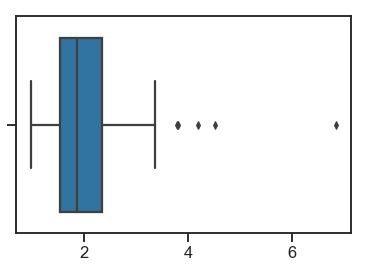

In [87]:
# There are a few high RT participants. These are not excluded and don't change the results drastically. Just worth knowing. 
checkRT = dataForPlot.pivot_table(index='participant',values='Trials_responsert',aggfunc='max')
sns.boxplot(checkRT)

In [88]:
#Pivot and recode data. This pivots the data so we can plot it. It also creates some useful contrasts


pivoted = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)
pivotedAllFour = dataForPlot.pivot_table(index='participant',columns=['condition','prompt1'],values='Trials_responsert',aggfunc=np.mean)
conditionMean = dataForPlot.pivot_table(index='participant',columns=['condition'],values='Trials_responsert',aggfunc=np.mean)
grandMean = dataForPlot.pivot_table(index='participant',values='Trials_responsert',aggfunc=np.mean)


for i in pivoted.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivoted because they have no data.")

pivoted = pivoted.dropna() #if any cells are missing, this'll run so we can still plot stuff. 

for i in pivotedAllFour.isnull().sum():
    if i > 0:
        print("We had to drop ",i," cells from pivotedAllFour because they have no data.")
pivotedAllFour = pivotedAllFour.dropna()        


# A few things to calculate
pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2


# Here, we slice the data differently, just by prompt.
pivotedAllFour['Friz_Back_minus_Fore'] = pivotedAllFour['Frisbee']['Left'] - pivotedAllFour['Frisbee']['Right']
pivotedAllFour['Friz_Home_minus_Away'] = pivotedAllFour['Frisbee']['Home'] - pivotedAllFour['Frisbee']['Away']
pivotedAllFour['Nav_Left_minus_Right'] = pivotedAllFour['Navigation']['Left'] - pivotedAllFour['Navigation']['Right']
pivotedAllFour['Nav_Home_minus_Away'] = pivotedAllFour['Navigation']['Home'] - pivotedAllFour['Navigation']['Away']


# Just planning to merge everything
pivoted.sort_index(inplace=True)
pivotedAllFour.sort_index(inplace=True)

# Merges pivoted data with additional data (columns from necessaryAdditionalData)
pivoted = pivoted.merge(necessaryAdditionalData,left_index=True,right_index=True)
conditionMean['participant'] = conditionMean.index
conditionMean[['participant']] = conditionMean[['participant']].apply(pd.to_numeric)
pivoted = pivoted.merge(conditionMean,left_index=True,right_index=True)
allpivots = pd.merge(pivotedAllFour,pivoted,right_index=True,left_index=True)
mi = allpivots.columns
ind = pd.Index([e[0] + e[1] for e in mi.tolist()])
allpivots.columns = ind

pivoted = pivotedAllFour.merge(pivoted,left_index=True,right_index=True)

grandMean['participant'] = grandMean.index
grandMean[['participant']] = grandMean[['participant']].apply(pd.to_numeric)
pivoted = grandMean.merge(pivoted,left_index=True,right_index=True)
mainDF = pivoted[:]

# This will rename columns to make things simpler. 
for i in mainDF.columns:
    if type(i)==tuple:
        a = '_'.join(i)
        a = a.rstrip('_')
        mainDF.rename(columns = {i:a}, inplace = True)

        


In [90]:
# Save datasets used

allData = dataForPlot.merge(necessaryAdditionalData,left_index=True,right_index=True)

#Data to export: 
df.to_csv('dataForCorr_for_R.csv')
allData.to_csv('dataForRT_for_R.csv')


In [22]:
print('Average age:',mainDF.Age.mean(),'\nStandard deviation age:', mainDF.Age.std())

Average age: 27.5 
Standard deviation age: 8.13321110060581


# Pre-registered Analyses
The correlation between relative / absolute reference frame preference for road intersection and ultimate frisbee.

0.07738777703634436

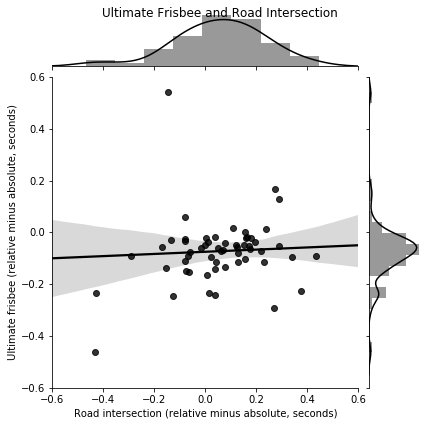

In [23]:
nav_and_friz = sns.jointplot(mainDF['Nav_Rel_minus_Abs'], mainDF['Frisbee_Rel_minus_Abs'], kind="reg",height = 6,color='black')
nav_and_friz.set_axis_labels('Road intersection (relative minus absolute, seconds)', 
                             'Ultimate frisbee (relative minus absolute, seconds)')
plt.xlim(-.6,.6)
plt.ylim(-.6,.6)
nav_and_friz.fig.suptitle('Ultimate Frisbee and Road Intersection')
plt.savefig('main_analysis_scatter.pdf',transparent=True)

navFrizCorr = np.corrcoef(mainDF['Nav_Rel_minus_Abs'], mainDF['Frisbee_Rel_minus_Abs'])
navFrizCorr = navFrizCorr[0,1]
display(navFrizCorr)

The correlation between relative / absolute reference frame preference for road intersection and ultimate frisbee with SBSOD and frisbee playing experience

Average ultimate frisbee playing in years: 7.78
Standard deviation ultimate frisbee playing in years: 5.03


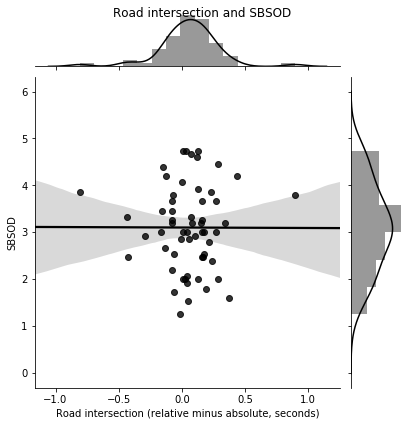

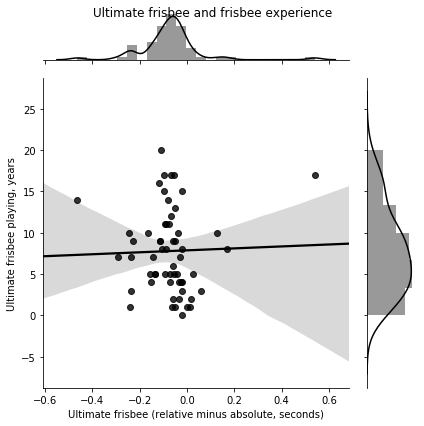

Navigation correlation: -0.002623078810223564 
Frisbee Correlation: 0.030034989636992922


In [24]:
print('Average ultimate frisbee playing in years: {:.2f}\nStandard deviation ultimate frisbee playing in years: {:.2f}'
      .format(mainDF.Friz_Total_Years_Played.mean(), mainDF.Friz_Total_Years_Played.std()))


nav_pref_SBSOD = sns.jointplot(mainDF['Nav_Rel_minus_Abs'], mainDF['SBSOD_AVERAGE'], kind="reg", height =6,color='black')
nav_pref_SBSOD.set_axis_labels('Road intersection (relative minus absolute, seconds)', 'SBSOD')
nav_pref_SBSOD.fig.suptitle('Road intersection and SBSOD')

plt.savefig('nav_scatter.pdf',transparent=True)


friz_pref_exp = sns.jointplot(mainDF['Frisbee_Rel_minus_Abs'], mainDF['Friz_Total_Years_Played'], kind="reg", height =6,color='black')
friz_pref_exp.set_axis_labels('Ultimate frisbee (relative minus absolute, seconds)','Ultimate frisbee playing, years')
friz_pref_exp.fig.suptitle('Ultimate frisbee and frisbee experience')

plt.savefig('friz_scatter.pdf',transparent=True)

plt.tight_layout()
plt.show()


navCorr = np.corrcoef(mainDF['Nav_Rel_minus_Abs'], mainDF['SBSOD_AVERAGE'])

frizCorr = np.corrcoef(mainDF['Frisbee_Rel_minus_Abs'], mainDF['Friz_Total_Years_Played'])


print('Navigation correlation:',navCorr[0,1],'\nFrisbee Correlation:', frizCorr[0,1])

# Exploratory Analyses
## Accuracy

Accuracy for condition overall
condition
Frisbee       0.974946
Navigation    0.902478
Name: Trials_responsecorr, dtype: float64
condition
Frisbee       0.034125
Navigation    0.095708
Name: Trials_responsecorr, dtype: float64


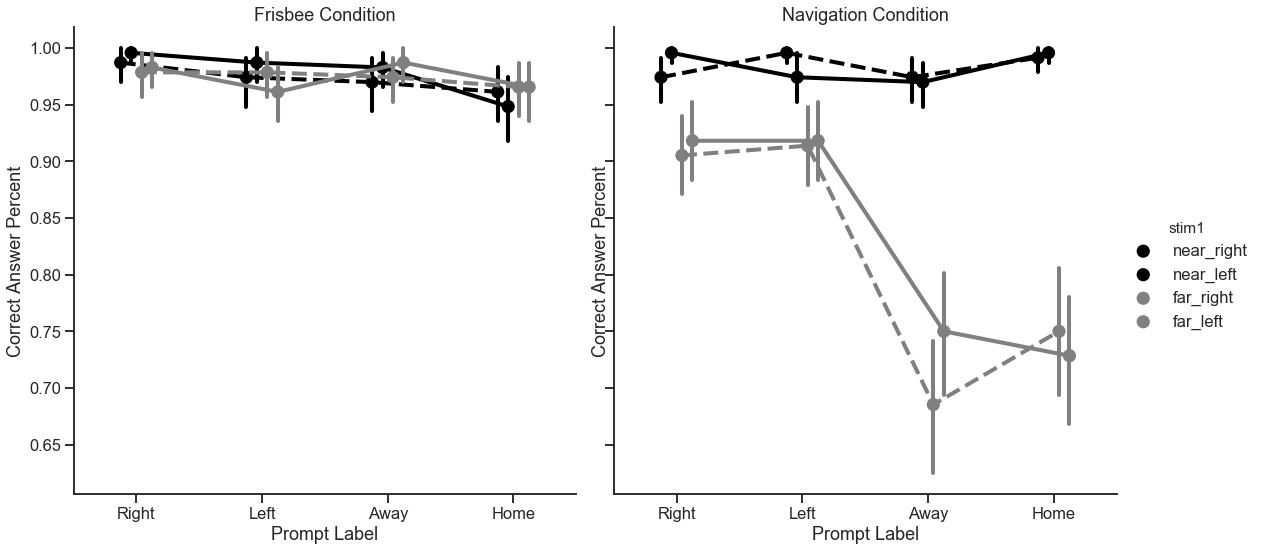

In [58]:
# We use df here, rather than mainDF because we need to not exclude any trials. 

print('Accuracy for condition overall')
print(df.groupby(['condition'])['Trials_responsecorr'].mean())
print(df.groupby(['condition', 'participant']).mean()
            .groupby('condition')['Trials_responsecorr'].std())


# Pivot table of correct trials, sorted by Far-Absolute navigation trials. 
# Commented out for brevity.
# display(pivotedCorrectAns.sort_values([('Navigation','Far','Absolute')]))

# Note: Forehand is coded as "left" and Backhand is coded as "Right"

correct_ans = sns.catplot(x = "prompt1", 
                             y = "Trials_responsecorr", 
                             data = df, 
                             hue = "stim1", 
                             palette=['black','black','grey','grey'],
                             linestyles=["--", "-","--","-"],
                             kind = "point", 
                             height = 8,
                             col = 'condition', 
                             order = ['Right','Left','Away','Home'], 
                             hue_order = ['near_right','near_left','far_right','far_left'],
                             dodge = .25)

correct_ans.set(xlabel='Prompt Label', ylabel='Correct Answer Percent')
correct_ans.set_titles("{col_name} Condition")

plt.savefig('four_conditions_accuracy_line_graph.pdf',transparent=True)
plt.show()



### See R-script for 2x2x2 ANOVA

## All pairwise ttests for accuracy

In [26]:
# Again, using df to include all trials. 
pivotedCorr = df.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],
                                  values='Trials_responsecorr',aggfunc=np.mean)


print('Bonferroni corrected error rate = {:.3f}\n'.format(.05/28))
for i in range(0,8):
    for j in range(1,8):
        if i < j:
            ttestAndMeansSDswithin(pivotedCorr.iloc[:,i],pivotedCorr.iloc[:,j],pivotedCorr,pivotedCorr.iloc[:,i].name,pivotedCorr.iloc[:,j].name)



Bonferroni corrected error rate = 0.002

('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Far', 'Relative') M = 0.98, SD = 0.06
 t(57) = 0.25, p = 0.80, d = 0.03
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Near', 'Absolute') M = 0.97, SD = 0.05
 t(57) = 0.78, p = 0.44, d = 0.10
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Frisbee', 'Near', 'Relative') M = 0.99, SD = 0.03
 t(57) = 1.57, p = 0.12, d = 0.22
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Far', 'Absolute') M = 0.73, SD = 0.37
 t(57) = 4.94, p = 0.0000, d = 0.81
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Far', 'Relative') M = 0.91, SD = 0.09
 t(57) = 4.03, p = 0.0002, d = 0.54
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Near', 'Absolute') M = 0.98, SD = 0.03
 t(57) = 1.05, p = 0.30, d = 0.14
('Frisbee', 'Far', 'Absolute') M = 0.97, SD = 0.06;  ('Navigation', 'Near', 'Relative') M = 0.98, SD = 0.03
 t(57) 

### Flippers and non-flippers.

In [27]:
flippersCorrNoNFA = flippersCorr.drop([('Navigation','Far','Absolute')],axis=1)
nonflippersCorrNoNFA = nonflippersCorr.drop([('Navigation','Far','Absolute')],axis=1)


justNavMeanFlippers = flippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)
justNavMeanNonFlippers = nonflippersCorrNoNFA.drop([('Frisbee')],axis=1).mean(axis=1)

justFrizMeanFlippers = flippersCorrNoNFA.drop([('Navigation')],axis=1).mean(axis=1)
justFrizMeanNonFlippers = nonflippersCorrNoNFA.drop([('Navigation')],axis=1).mean(axis=1)

# Flipper and non-flipper accuracy on non-Far-Absolute road intersection trials
ttestAndMeansSDs(justNavMeanFlippers,justNavMeanNonFlippers,'Nav Flippers', 'Nav Non-Flippers')
# Flipper and non-flipper accuracy on all ultimate frisbee trials
ttestAndMeansSDs(justFrizMeanFlippers,justFrizMeanNonFlippers, 'Friz Flippers','Friz Non-flippers')


Nav Flippers M = 15.47, SD = 0.54;  Nav Non-Flippers M = 15.33, SD = 0.63
 t(56) = 0.83, p = 0.41, d = 0.25
Friz Flippers M = 15.47, SD = 0.79;  Friz Non-flippers M = 15.65, SD = 0.40
 t(56) = 1.16, p = 0.25, d = 0.29


In [28]:
# flippers and non-flippers differ on on relative (not absolute) reaction times! 
for i in flippersRT:
    ttestAndMeansSDs(flippersRT[i],nonflippersRT[i],'flippers {}'.format(i),'nonflippers {}'.format(i))

flippers ('Frisbee', 'Far', 'Absolute') M = 1.45, SD = 0.87;  nonflippers ('Frisbee', 'Far', 'Absolute') M = 1.27, SD = 0.39
 t(56) = 1.11, p = 0.27, d = 0.27
flippers ('Frisbee', 'Far', 'Relative') M = 1.30, SD = 0.81;  nonflippers ('Frisbee', 'Far', 'Relative') M = 1.16, SD = 0.34
 t(56) = 0.97, p = 0.33, d = 0.24
flippers ('Frisbee', 'Near', 'Absolute') M = 1.33, SD = 0.51;  nonflippers ('Frisbee', 'Near', 'Absolute') M = 1.20, SD = 0.36
 t(56) = 1.07, p = 0.29, d = 0.29
flippers ('Frisbee', 'Near', 'Relative') M = 1.24, SD = 0.72;  nonflippers ('Frisbee', 'Near', 'Relative') M = 1.10, SD = 0.37
 t(56) = 1.00, p = 0.32, d = 0.25
flippers ('Navigation', 'Far', 'Absolute') M = 1.58, SD = 0.55;  nonflippers ('Navigation', 'Far', 'Absolute') M = 1.09, SD = 0.45
 t(56) = 3.53, p = 0.0008, d = 0.98
flippers ('Navigation', 'Far', 'Relative') M = 1.34, SD = 0.33;  nonflippers ('Navigation', 'Far', 'Relative') M = 1.38, SD = 0.52
 t(56) = 0.30, p = 0.76, d = 0.09
flippers ('Navigation', 'Nea

In [29]:

display(flippersOtherData.groupby(['Friz_Force_Preference'])['Friz_Position'].count())
display(nonflippersOtherData.groupby(['Friz_Force_Preference'])['Friz_Position'].count())

display(flippersOtherData.groupby('Sex')['Sex'].count())
display(nonflippersOtherData.groupby('Sex')['Sex'].count())




Friz_Force_Preference
Forehand / Backhand     2
Home / Away            13
Name: Friz_Position, dtype: int64

Friz_Force_Preference
Forehand / Backhand    17
Home / Away            19
Name: Friz_Position, dtype: int64

Sex
female     3
male      14
Name: Sex, dtype: int64

Sex
female    15
male      26
Name: Sex, dtype: int64

## Reaction Time

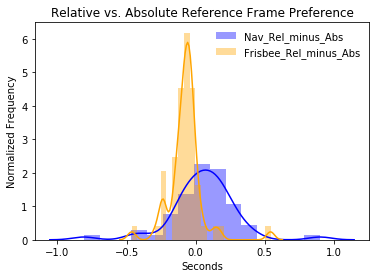

Frisbee M = -0.07, SD = 0.13;  Navigation M = 0.06, SD = 0.24
 t(57) = 3.75, p = 0.0004, d = 1.02


Ttest_1sampResult(statistic=-4.311439199015634, pvalue=6.499538552823332e-05)

Ttest_1sampResult(statistic=1.7917670702272934, pvalue=0.07847889259261333)

LeveneResult(statistic=10.41413885070387, pvalue=0.0016328931661096396)

In [30]:
# Ultimate frisbee versus road intersection task overall reaction time differences.

doubleDistPlot('Frisbee_Rel_minus_Abs',
               'Nav_Rel_minus_Abs',
               mainDF,abs_and_rel=False,
               title='Relative vs. Absolute Reference Frame Preference',
               blackWhite = False,saveFig='RT_bias.pdf')


# Ultimate frisbee versus road intersection t-test
ttestAndMeansSDswithin(mainDF['Frisbee_Rel_minus_Abs'],mainDF['Nav_Rel_minus_Abs'],mainDF,'Frisbee', 'Navigation')

# One Sample t-tests
display(scipy.stats.ttest_1samp(mainDF['Frisbee_Rel_minus_Abs'],0))
display(scipy.stats.ttest_1samp(mainDF['Nav_Rel_minus_Abs'],0))

# Significantly different variances
scipy.stats.levene(mainDF['Frisbee_Rel_minus_Abs'],mainDF['Nav_Rel_minus_Abs'])

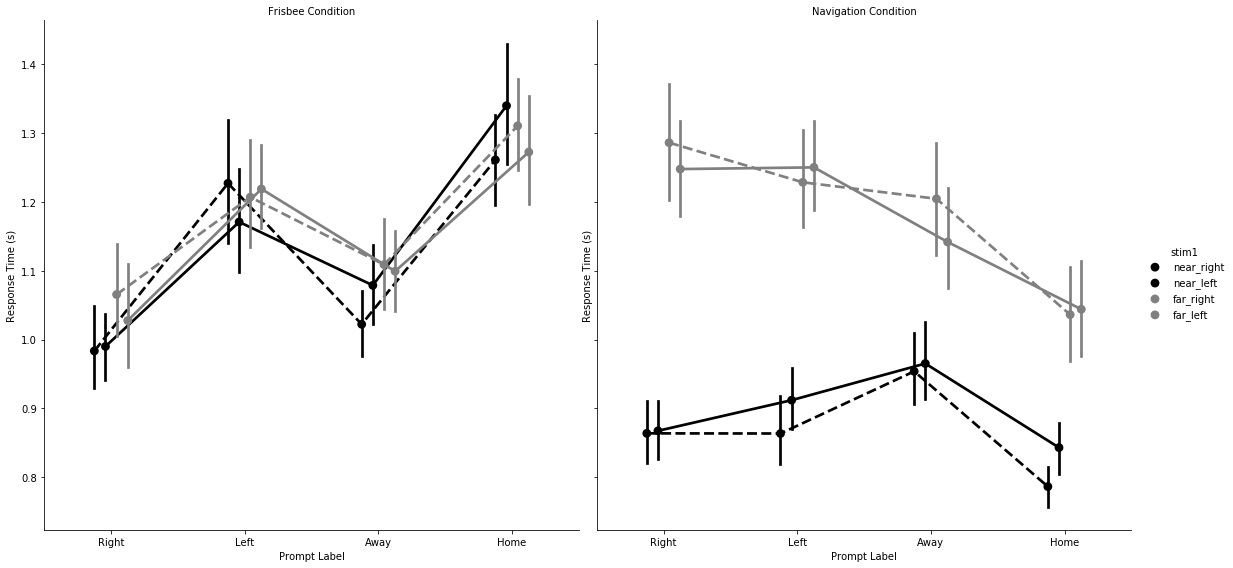

In [31]:
ax2 = sns.catplot(x = "prompt1", 
                     y = "Trials_responsert", 
                     data = dataForPlot, 
                     hue = "stim1", 
                     palette = ['black','black','grey','grey'],
                     linestyles = ['--','-','--','-'],
                     kind = "point", 
                     height = 8,
                     col = 'condition', 
                     order = ['Right','Left','Away','Home'], 
                     hue_order = ['near_right','near_left','far_right','far_left'],
                     dodge = .25)

ax2.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax2.set_titles("{col_name} Condition")
plt.savefig('four_conditions_rt_line_graph.pdf',transparent=True)
plt.show()

### See R-script for repeated-measures ANOVA


count    6824.000000
mean        1.082661
std         0.501914
min         0.336000
25%         0.767000
50%         0.952000
75%         1.249000
max         6.838000
Name: Trials_responsert, dtype: float64

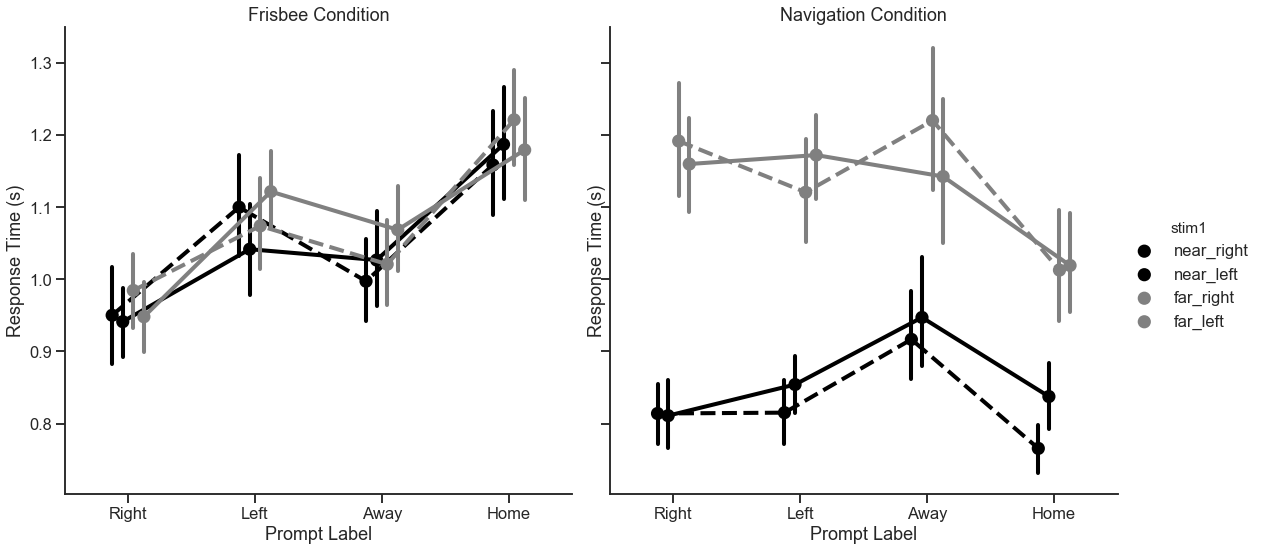

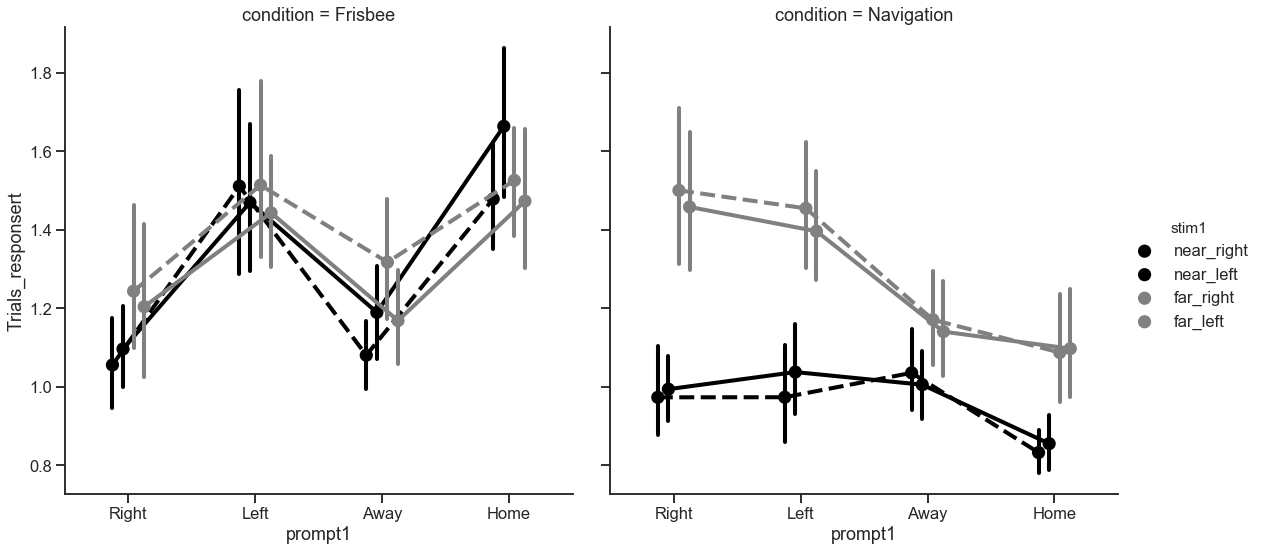

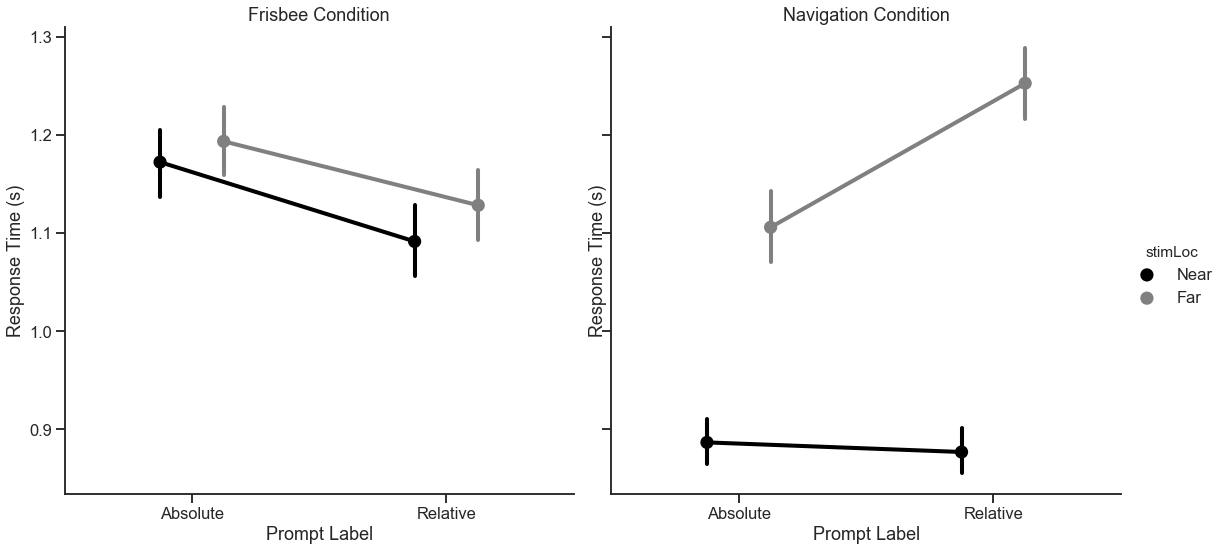

In [33]:
sns.set_style('ticks')
sns.set_context('talk')
ax1 = sns.catplot(x = "promptType", 
                     y = "Trials_responsert", 
                     data = dataForPlot,
                     hue="stimLoc",
                     palette=['black','grey'], 
                     kind = "point", 
                     height = 8,
                     col='condition',
                     dodge = .25)

ax1.set(xlabel='Prompt Label', ylabel='Response Time (s)')

ax1.set_titles("{col_name} Condition")


plt.savefig('two_conditions_rt_line_graph.pdf',transparent=True)


Index(['Trials_responsert', 'participant_x', 'Frisbee_Away', 'Frisbee_Home',
       'Frisbee_Left', 'Frisbee_Right', 'Navigation_Away', 'Navigation_Home',
       'Navigation_Left', 'Navigation_Right', 'Friz_Back_minus_Fore',
       'Friz_Home_minus_Away', 'Nav_Left_minus_Right', 'Nav_Home_minus_Away',
       'Frisbee_Far_Absolute', 'Frisbee_Far_Relative', 'Frisbee_Near_Absolute',
       'Frisbee_Near_Relative', 'Navigation_Far_Absolute',
       'Navigation_Far_Relative', 'Navigation_Near_Absolute',
       'Navigation_Near_Relative', 'Frisbee_Rel_minus_Abs_Far',
       'Frisbee_Rel_minus_Abs_Near', 'Frisbee_Rel_minus_Abs',
       'Nav_Rel_minus_Abs_Far', 'Nav_Rel_minus_Abs_Near', 'Nav_Rel_minus_Abs',
       'Sex', 'Age', 'SBSOD_AVERAGE', 'Friz_Total_Years_Played',
       'Friz_Force_Preference', 'Friz_Position', 'Friz_Handedness',
       'Friz_First_is_1', 'Frisbee', 'Navigation', 'participant_y'],
      dtype='object')

In [35]:

pivotedRTstim = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc'],
                                  values='Trials_responsert',aggfunc=np.mean)


print('Bonferroni corrected error rate = {:.3f}\n'.format(.05/6))
for i in range(0,4):
    for j in range(1,4):
        if i < j:
            ttestAndMeansSDswithin(pivotedRTstim.iloc[:,i],pivotedRTstim.iloc[:,j],pivotedRTstim,pivotedRTstim.iloc[:,i].name,pivotedRTstim.iloc[:,j].name)

            
pivotedRTprompt = dataForPlot.pivot_table(index='participant',columns=['condition','promptType'],
                                  values='Trials_responsert',aggfunc=np.mean)


print('Bonferroni corrected error rate = {:.3f}\n'.format(.05/6))
for i in range(0,4):
    for j in range(1,4):
        if i < j:
            ttestAndMeansSDswithin(pivotedRTprompt.iloc[:,i],pivotedRTprompt.iloc[:,j],pivotedRTprompt,pivotedRTprompt.iloc[:,i].name,pivotedRTprompt.iloc[:,j].name)

            

            

Bonferroni corrected error rate = 0.008

('Frisbee', 'Far') M = 1.17, SD = 0.40;  ('Frisbee', 'Near') M = 1.13, SD = 0.36
 t(57) = 2.39, p = 0.02, d = 0.33
('Frisbee', 'Far') M = 1.17, SD = 0.40;  ('Navigation', 'Far') M = 1.18, SD = 0.38
 t(57) = 0.15, p = 0.88, d = 0.02
('Frisbee', 'Far') M = 1.17, SD = 0.40;  ('Navigation', 'Near') M = 0.88, SD = 0.21
 t(57) = 7.57, p = 0.0000, d = 1.24
('Frisbee', 'Near') M = 1.13, SD = 0.36;  ('Navigation', 'Far') M = 1.18, SD = 0.38
 t(57) = 1.39, p = 0.17, d = 0.18
('Frisbee', 'Near') M = 1.13, SD = 0.36;  ('Navigation', 'Near') M = 0.88, SD = 0.21
 t(57) = 8.38, p = 0.0000, d = 1.42
('Navigation', 'Far') M = 1.18, SD = 0.38;  ('Navigation', 'Near') M = 0.88, SD = 0.21
 t(57) = 10.50, p = 0.0000, d = 2.13
Bonferroni corrected error rate = 0.008

('Frisbee', 'Absolute') M = 1.19, SD = 0.35;  ('Frisbee', 'Relative') M = 1.12, SD = 0.39
 t(57) = 4.39, p = 0.0000, d = 0.60
('Frisbee', 'Absolute') M = 1.19, SD = 0.35;  ('Navigation', 'Absolute') M = 

## Split data by frisbee preference

In [36]:
print(mainDF.Friz_Force_Preference.value_counts())

absDF = mainDF[mainDF['Friz_Force_Preference']=='Home / Away']
relDF = mainDF[mainDF['Friz_Force_Preference']=='Forehand / Backhand']

totalTests = 0
for i in mainDF:
    if np.issubdtype(mainDF[i].dtype, np.number):
        totalTests += 1
        t,p = scipy.stats.ttest_ind(absDF[i],relDF[i])
        if p < .05:
            print(i)
            ttestAndMeansSDs(absDF[i],relDF[i])
print('\nBonferonni correction = {}'.format(.05/totalTests))




Home / Away            32
Forehand / Backhand    19
Name: Friz_Force_Preference, dtype: int64
Nav_Rel_minus_Abs_Far
dv1 M = 0.02, SD = 0.33;  dv2 M = 0.30, SD = 0.28
 t(49) = 3.10, p = 0.003, d = 0.92
Nav_Rel_minus_Abs
dv1 M = -0.02, SD = 0.22;  dv2 M = 0.17, SD = 0.22
 t(49) = 2.97, p = 0.005, d = 0.86

Bonferonni correction = 0.0014285714285714286



T = -3.10, p = 0.003201
dv1 M = 0.02, SD = 0.33;  dv2 M = 0.30, SD = 0.28
 t(49) = 3.10, p = 0.003, d = 0.92


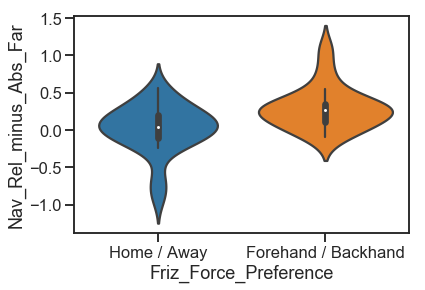

In [37]:
sns.violinplot(x=mainDF['Friz_Force_Preference'], y=mainDF['Nav_Rel_minus_Abs_Far'])

t,p = scipy.stats.ttest_ind(absDF['Nav_Rel_minus_Abs_Far'],relDF['Nav_Rel_minus_Abs_Far'])
print('\nT = {:.2f}, p = {:.6f}'.format(t,p))

ttestAndMeansSDs(absDF['Nav_Rel_minus_Abs_Far'],relDF['Nav_Rel_minus_Abs_Far'])


T = -2.97, p = 0.004652


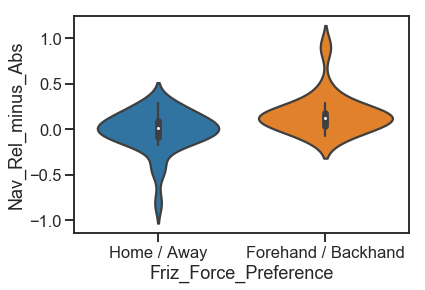

In [38]:
sns.violinplot(x=mainDF['Friz_Force_Preference'], y=mainDF['Nav_Rel_minus_Abs'])

t,p = scipy.stats.ttest_ind(absDF['Nav_Rel_minus_Abs'],relDF['Nav_Rel_minus_Abs'])
print('\nT = {:.2f}, p = {:.6f}'.format(t,p))



T = 1.35, p = 0.183499


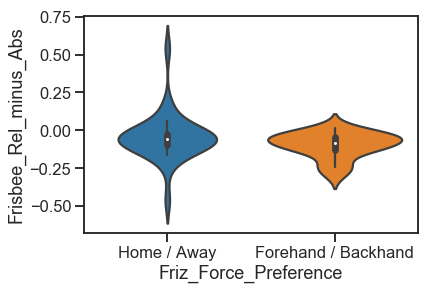

In [39]:
sns.violinplot(x=mainDF['Friz_Force_Preference'], y=mainDF['Frisbee_Rel_minus_Abs'])

t,p = scipy.stats.ttest_ind(absDF['Frisbee_Rel_minus_Abs'],relDF['Frisbee_Rel_minus_Abs'])
print('\nT = {:.2f}, p = {:.6f}'.format(t,p))

## Split data by frisbee position

In [40]:
print(mainDF.Friz_Position.value_counts())

handlerDF = mainDF[mainDF['Friz_Position']=='Handler']
cutterDF = mainDF[mainDF['Friz_Position']=='Cutter']

totalTests = 0
for i in mainDF:
    if np.issubdtype(mainDF[i].dtype, np.number):
        totalTests += 1
        t,p = scipy.stats.ttest_ind(handlerDF[i],cutterDF[i])
        if p < .05:
            print(i)
            ttestAndMeansSDs(handlerDF[i],cutterDF[i])
print('\nBonferonni correction = {}'.format(.05/totalTests))


Cutter     26
Both       20
Handler    12
Name: Friz_Position, dtype: int64
Frisbee_Rel_minus_Abs_Far
dv1 M = -0.01, SD = 0.12;  dv2 M = -0.10, SD = 0.09
 t(36) = 2.72, p = 0.010, d = 0.89
SBSOD_AVERAGE
dv1 M = 3.54, SD = 0.62;  dv2 M = 2.77, SD = 0.93
 t(36) = 2.61, p = 0.01, d = 0.98

Bonferonni correction = 0.0014285714285714286



T = 2.72, p = 0.009986


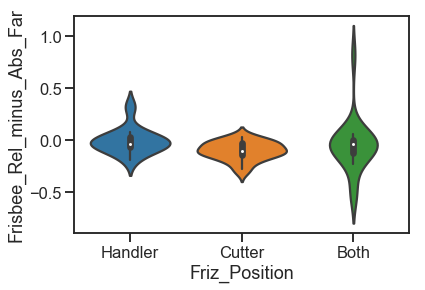

In [41]:
sns.violinplot(x=mainDF['Friz_Position'], y=mainDF['Frisbee_Rel_minus_Abs_Far'])


t,p = scipy.stats.ttest_ind(handlerDF['Frisbee_Rel_minus_Abs_Far'],cutterDF['Frisbee_Rel_minus_Abs_Far'])
print('\nT = {:.2f}, p = {:.6f}'.format(t,p))


T = 2.61, p = 0.013219


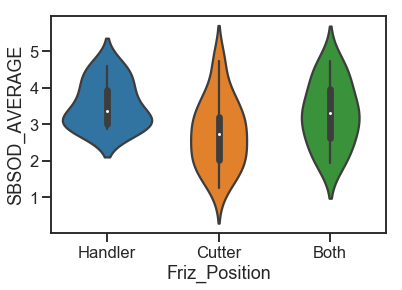

In [42]:
sns.violinplot(x=mainDF['Friz_Position'], y=mainDF['SBSOD_AVERAGE'])


t,p = scipy.stats.ttest_ind(handlerDF['SBSOD_AVERAGE'],cutterDF['SBSOD_AVERAGE'])
print('\nT = {:.2f}, p = {:.6f}'.format(t,p))

In [43]:
additionalData.Friz_Force_Preference.value_counts()

Home / Away            32
Forehand / Backhand    19
Name: Friz_Force_Preference, dtype: int64

Friz_Force_Preference,Forehand / Backhand,Home / Away
Sex,,
female,8,8
male,11,24


## Order of completion t-tests

In [44]:
print(mainDF.Friz_First_is_1.value_counts())

firstDF = mainDF[mainDF['Friz_First_is_1']==2]
secondDF = mainDF[mainDF['Friz_First_is_1']==1]

totalTests = 0
for i in mainDF:
    if np.issubdtype(mainDF[i].dtype, np.number):
        totalTests += 1
        t,p = scipy.stats.ttest_ind(firstDF[i],secondDF[i])
        if p < .05:
            print(i)
            ttestAndMeansSDs(firstDF[i],secondDF[i])
print('\nBonferonni correction = {}'.format(.05/totalTests))


2    32
1    26
Name: Friz_First_is_1, dtype: int64
Navigation_Away
dv1 M = 1.16, SD = 0.44;  dv2 M = 0.97, SD = 0.22
 t(56) = 2.02, p = 0.05, d = 0.55
Friz_First_is_1
dv1 M = 2.00, SD = 0.00;  dv2 M = 1.00, SD = 0.00
 t(56) = inf, p = 0.0000, d = inf

Bonferonni correction = 0.0014285714285714286


## Split data by Gender


In [105]:
print(mainDF.Sex.value_counts())

maleDF = mainDF[mainDF['Sex']=='male']
femaleDF = mainDF[mainDF['Sex']=='female']

totalTests = 0
for i in mainDF:
    if np.issubdtype(mainDF[i].dtype, np.number):
        totalTests += 1
        t,p = scipy.stats.ttest_ind(maleDF[i],femaleDF[i])
        if p < .05:
            print(i)
            ttestAndMeansSDs(maleDF[i],femaleDF[i],'Men','Women')
print('\nBonferonni correction = {}'.format(.05/totalTests))

male      40
female    18
Name: Sex, dtype: int64
Trials_responsert
Men M = 1.02, SD = 0.23;  Women M = 1.23, SD = 0.39
 t(56) = 2.60, p = 0.01, d = 0.66
Frisbee_Away
Men M = 1.03, SD = 0.24;  Women M = 1.21, SD = 0.41
 t(56) = 2.07, p = 0.04, d = 0.53
Frisbee_Home
Men M = 1.19, SD = 0.30;  Women M = 1.56, SD = 0.60
 t(56) = 3.17, p = 0.002, d = 0.79
Frisbee_Left
Men M = 1.08, SD = 0.27;  Women M = 1.55, SD = 0.79
 t(56) = 3.36, p = 0.001, d = 0.79
Frisbee_Right
Men M = 0.95, SD = 0.23;  Women M = 1.15, SD = 0.45
 t(56) = 2.21, p = 0.03, d = 0.55
Navigation_Left
Men M = 0.97, SD = 0.20;  Women M = 1.21, SD = 0.40
 t(56) = 3.06, p = 0.003, d = 0.76
Navigation_Right
Men M = 0.98, SD = 0.21;  Women M = 1.20, SD = 0.44
 t(56) = 2.67, p = 0.010, d = 0.66
Friz_Back_minus_Fore
Men M = 0.13, SD = 0.15;  Women M = 0.40, SD = 0.44
 t(56) = 3.48, p = 0.0010, d = 0.82
Friz_Home_minus_Away
Men M = 0.16, SD = 0.14;  Women M = 0.35, SD = 0.38
 t(56) = 2.80, p = 0.007, d = 0.66
Frisbee_Far_Absolute
Me

0.22330373896440966

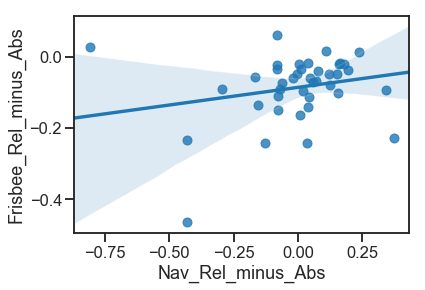

In [46]:
byGender = sns.regplot(x = 'Nav_Rel_minus_Abs', y = 'Frisbee_Rel_minus_Abs', data = maleDF)
byGenderCorr = np.corrcoef(maleDF['Nav_Rel_minus_Abs'], maleDF['Frisbee_Rel_minus_Abs'])
byGenderCorr = byGenderCorr[0,1]
display(byGenderCorr)

-0.21810748316701783

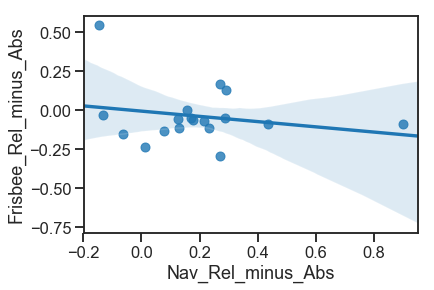

In [48]:
byGender = sns.regplot(x = 'Nav_Rel_minus_Abs', y = 'Frisbee_Rel_minus_Abs', data = femaleDF)
byGenderCorr = np.corrcoef(femaleDF['Nav_Rel_minus_Abs'], femaleDF['Frisbee_Rel_minus_Abs'])
byGenderCorr = byGenderCorr[0,1]
display(byGenderCorr)

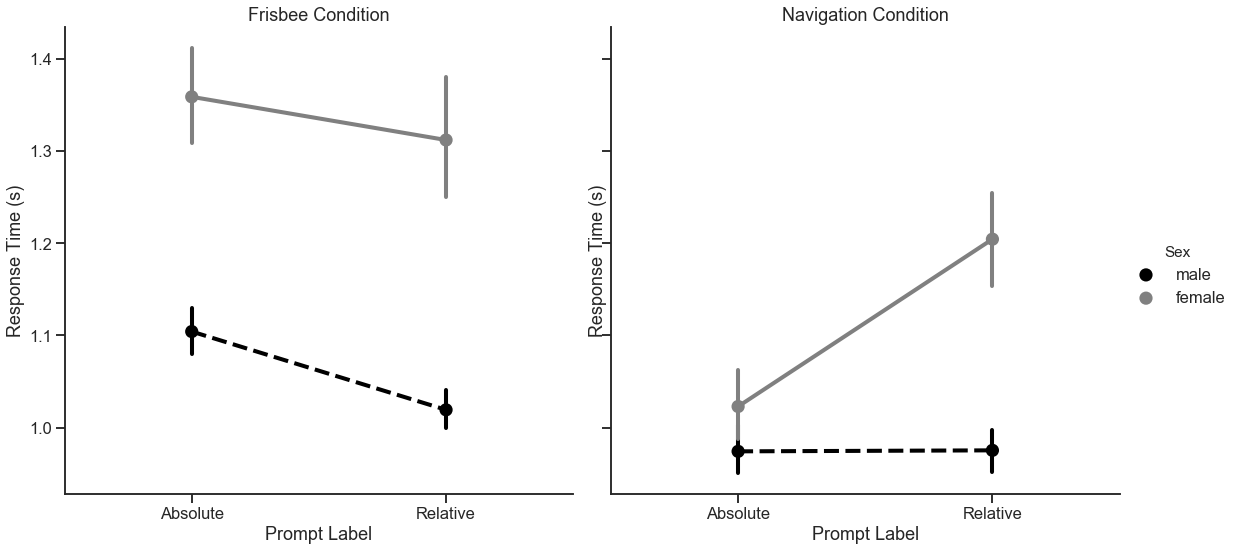

In [115]:

maleDFLong = allData[allData['Sex']=='male']
femaleDFLong = allData[allData['Sex']=='female']

ax2 = sns.catplot(x = "promptType", 
                     y = "Trials_responsert", 
                     data = allData, 
                     hue = "Sex", 
                     palette = ['black','grey'],
                     linestyles = ['--','-','--','-'],
                     kind = "point", 
                     height = 8,
                     col = 'condition')

ax2.set(xlabel='Prompt Label', ylabel='Response Time (s)')
ax2.set_titles("{col_name} Condition")
#plt.savefig('four_conditions_rt_line_graph.pdf',transparent=True)
plt.show()



In [116]:
pd.crosstab(additionalData.Sex,additionalData.Friz_Force_Preference)

Friz_Force_Preference,Forehand / Backhand,Home / Away
Sex,,
female,8,8
male,11,24
